<a href="https://colab.research.google.com/github/dolmani38/drift/blob/main/synthetic_data_generation_1112.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
if True:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# 30개의 feature x1~x30
# y = 1/0
# 30개의 weight w1~w30

array([ 1.32721340e+00,  7.13674027e-01,  4.15374988e-01,  1.37167483e+00,
        5.27115606e-01, -9.61980505e-01,  1.05229089e+00,  1.37304179e+00,
       -3.46609285e-02,  9.72252963e-01,  8.07366875e-01,  1.35673844e+00,
        2.23913758e+00,  1.17896408e+00,  2.53185170e+00,  4.85110852e-02,
        1.92054897e-01,  1.33708471e+00, -6.91017997e-01,  2.76229897e-01,
        5.69938811e-01,  2.21030362e+00,  1.49948553e+00,  8.81079859e-01,
        6.27062448e-01,  6.38838729e-01, -7.92205439e-01,  1.35539164e+00,
        1.17493311e+00,  3.30392628e-01,  1.19392906e+00,  2.19771655e+00,
        2.13001311e+00, -1.95826514e-01,  1.60858158e+00,  1.56417780e+00,
        1.61021719e+00,  1.29288805e+00, -6.13570191e-01,  1.39721349e+00,
        1.26543072e+00,  9.34580083e-01,  9.09385629e-01, -4.63103482e-01,
        2.55132521e+00,  1.33127200e+00, -4.64532357e-01,  1.93986114e+00,
       -5.93704114e-01,  5.06035553e-01,  1.05335812e+00,  1.58579737e+00,
        1.13594241e+00,  

In [91]:
import random

data_x = {}
weight = {}
errors = []
for f in range(10):
    data_x[f'x{f}'] = []
    weight[f'w{f}'] = []
    d = random.uniform(-0.002, 0.002)
    w = random.uniform(0, 10)
    w_delta = random.uniform(-0.005, 0.005)
    for i in range(10000):
        data_x[f'x{f}'].extend(np.random.normal(1.0+(i*d),1.0,100))
        weight[f'w{f}'].extend(w + (w_delta*i)+np.random.normal(0.0,0.01,100))

for i in range(10000):        
    errors.extend(np.random.normal(1.0,2.0,100))

In [92]:
dataset = pd.DataFrame(data_x)
importance = pd.DataFrame(weight)

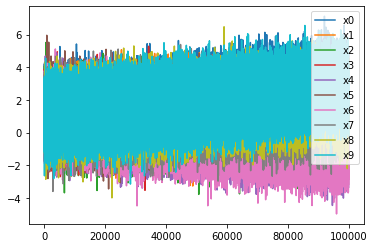

In [79]:
dataset.plot()

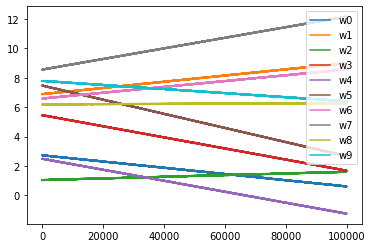

In [80]:
importance.plot()

In [53]:
def adj_weight(x):
    if x < 0.0:
        return 0.0
    return x+1-1

In [54]:
adj_weight(-1)

0.0

In [93]:
for f in range(10):
    importance[f'w{f}'] = importance[f'w{f}'].apply(adj_weight)

In [82]:
importance.shape

(100000, 10)

In [83]:
dataset.shape

(100000, 10)

In [84]:
len(errors)

100000

In [94]:
y=np.sum(np.multiply(importance.values,dataset.values),axis=1) + np.asarray(errors)

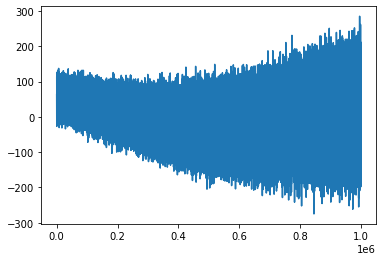

In [95]:
plt.plot(y)

In [96]:
dataset['y'] = [1 if i > 0 else 0 for i in y]

In [101]:
dataset

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,y
0,-0.436098,2.016749,0.143108,1.467411,0.424547,1.077912,1.703357,2.093790,0.742644,0.629767,1
1,-0.214423,1.704164,2.839124,1.613714,1.765123,1.849176,0.612850,-0.176687,-1.083774,-0.289538,1
2,1.727316,1.102070,1.054399,1.005548,0.597528,0.785501,0.190790,-0.084674,1.814378,1.210073,1
3,0.604143,0.908379,-0.002461,0.552422,2.394884,3.623380,0.849601,1.661799,1.727537,0.980628,1
4,2.736235,1.633641,0.502721,1.227504,3.253444,0.567363,-1.555482,2.736505,-0.286653,0.519170,1
...,...,...,...,...,...,...,...,...,...,...,...
999995,-9.395306,-9.304973,-13.976640,-5.049658,8.043084,17.798869,15.917025,-17.065351,17.482172,-15.326360,1
999996,-10.291800,-8.807786,-12.418769,-6.364509,8.397367,14.108351,18.398155,-17.545381,17.972564,-14.111775,0
999997,-8.915349,-8.102645,-12.469708,-5.829627,8.569982,17.266480,16.620278,-16.329832,16.700955,-16.840188,1
999998,-9.684141,-10.330952,-13.551626,-5.492569,7.223996,16.836514,16.840060,-18.222049,17.634282,-13.927758,0


In [98]:
dataset.to_csv('/content/drive/MyDrive/laos/synthetic_dataset_1.csv')

In [99]:
from sklearn.ensemble import RandomForestClassifier

In [102]:
trainset = dataset[0:100000].drop(columns=['y']).values
y = dataset[0:100000]['y'].values

In [135]:
business_model = RandomForestClassifier(n_estimators=80,max_depth=5)
business_model.fit(trainset,y)

RandomForestClassifier(max_depth=5, n_estimators=80)

In [107]:
testset = dataset[100000:110000].drop(columns=['y']).values
test_y = dataset[100000:110000]['y'].values

In [136]:
from sklearn.metrics import precision_recall_fscore_support

base_score = precision_recall_fscore_support(test_y, business_model.predict(testset),average='binary')

In [137]:
base_score

(0.9107769423558897, 1.0, 0.9533053515215111, None)

In [152]:

def __ks_2samp2(sample1, sample2):
    # Gets all observations
    sample1 = np.sort(sample1)
    sample2 = np.sort(sample2)
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]   
    data_all = np.concatenate([sample1, sample2])
    cdf1 = np.searchsorted(sample1, data_all, side='right') / n1
    cdf2 = np.searchsorted(sample2, data_all, side='right') / n2
    # Evaluates the KS statistic
    cddiffs = cdf1 - cdf2
    minS = -np.min(cddiffs)
    maxS = np.max(cddiffs)
    ks_stat =  max(minS, maxS)
    
    #if ks_stat == minS:
    #    ks_stat = -ks_stat
    
    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    m, n = float(n1), float(n2)
    en = m * n / (m + n)
    p_value = 0.0 #stats.kstwobign.sf(math.sqrt(en) * abs(ks_stat))
    #p_value = stats.kstwobign.sf(en * abs(ks_stat))
    return ks_stat,p_value

def __ks_drift(ref_x,inf_x):
    x_drift = np.zeros((ref_x.shape[1],2))
    for i in range(ref_x.shape[1]):
        #s, p = ks_2samp(ref_x[:,i],inf_x[:,i],mode='asymp')
        s, p = __ks_2samp2(ref_x[:,i],inf_x[:,i])
        x_drift[i,0] = s
        x_drift[i,1] = p
    return x_drift

In [119]:
X2 = dataset[110000:600000].drop(columns=['y']).values
Y2 = dataset[110000:600000]['y'].values

In [153]:
import math

result = {}
result['precision'] = []
result['predicted'] = []
result['drift'] = []
window_size = 5000
step = 2500
predicted = 0
batch = math.ceil((X2.shape[0]-window_size)/step)
for i in range(batch):
    ux = X2[i*step:i*step+window_size]
    uy = Y2[i*step:i*step+window_size]
    f1 = precision_recall_fscore_support(uy, business_model.predict(ux),average='binary')
    drift = __ks_drift(trainset,ux)
    result['precision'].append(f1[0])
    result['predicted'].append(0.0)
    result['drift'].append(sum(abs(drift[:,0])))

In [154]:
result_df = pd.DataFrame(result)

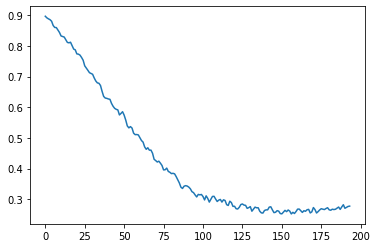

In [155]:
result_df['precision'].plot()

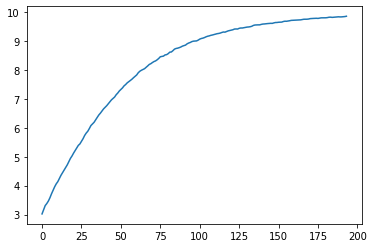

In [156]:
result_df['drift'].plot()

In [157]:
false_x = []
true_x = []

y_hat = business_model.predict(testset)

inx = 0
for yt,yp in zip(test_y,y_hat):
    if yt == yp:
        true_x.append(np.append(testset[inx],yt))
    else:
        false_x.append(np.append(testset[inx],yt))
    inx = inx + 1

true_x = np.asarray(true_x)
false_x = np.asarray(false_x)

In [159]:
import statsmodels.api as sm

def ppm_build(ratio = 100,epoch =1000):
    scores = []
    drifts = []

    sample_size = false_x.shape[0] * ratio
    aa = np.random.randint(1,sample_size,epoch)
    for i in range(epoch):
        tx = true_x[np.random.choice(true_x.shape[0], sample_size, replace=True)[0:aa[i]],:]
        fx = false_x #np.random.permutation(false_x)[0:np.random.randint(1,false_x.shape[0],1)[0]]
        #fx = np.random.permutation(false_x)[0:np.random.randint(1,false_x.shape[0],1)[0]]
        #tx = true_x[np.random.choice(true_x.shape[0], fx.shape[0] * ratio, replace=True)[0:np.random.randint(1,fx.shape[0] * ratio,1)[0]],:]
        ffx = np.concatenate((tx,fx))
        np.random.shuffle(ffx)
        tx = ffx[:,0:10]
        ty = ffx[:,10]
        base_score = precision_recall_fscore_support(ty, business_model.predict(tx),average='binary')
        #x_ref2 = np.random.permutation(x_ref)[0:tx.shape[0]]
        drift = __ks_drift(trainset,tx)
        scores.append(base_score[0])
        drifts.append(drift[:,0])
        print(f"\r{i+1}/{epoch} precision:{base_score[0]:.4f} drift:{drift[0,0]:.4f}", end="", flush=True)

    plt.hist(scores, bins = 100)
    plt.show()

    model = sm.OLS(scores, drifts).fit()
    print('Model R^2:',model.rsquared)
    return model

In [ ]:
ppmodel = ppm_build(ratio = 80,epoch =300)

140/300 precision:0.6736 drift:0.2647

In [150]:
from sklearn.metrics import r2_score

def test1(model):
    result = {}
    result['precision'] = []
    result['predicted'] = []
    window_size = 5000
    step = 2500
    predicted = 0
    batch = math.ceil((X2.shape[0]-window_size)/step)
    for i in range(batch):
        ux = X2[i*step:i*step+window_size]
        uy = Y2[i*step:i*step+window_size]
        f1 = precision_recall_fscore_support(uy, business_model.predict(ux),average='binary')

        drift = __ks_drift(trainset,ux)
        precision = f1[0]
        predicted1 = model.predict(drift[:,0])[0]
        if abs(predicted1-predicted) > 0.1 and predicted > 0:
            predicted1 = predicted
        result['precision'].append(precision)
        result['predicted'].append(predicted1)
        print(f"\r{i+1}/{batch} precision:{precision:.4f} predicted:{predicted1:.4f}", end="", flush=True)
        predicted = predicted1

    R2 = r2_score(result['precision'],result['predicted'])
    print('')
    print('R2:',R2)
    result_df = pd.DataFrame(result)
    result_df.plot()
    plt.show()
    return R2, result_df

194/194 precision:0.2774 predicted:2.2359
R2: -79.12325949777158


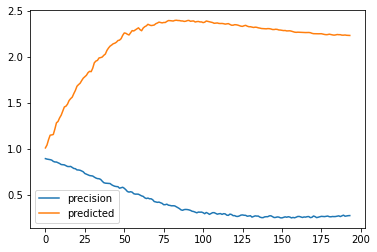

In [151]:
R2, result_df = test1(ppmodel)